In [15]:
pip install datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U molfeat

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.26.2.post1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
Using cached nvidia_nccl_cu12-2.26.2.post1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (291.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os

# Redirect Hugging Face cache to scratch or job-specific temp directory
os.environ['HF_HOME'] = '/home/vmsavla/turbo/vmsavla/opt/huggingface_cache'  # adjust if needed
os.environ['HF_DATASETS_CACHE'] = '/home/vmsavla/turbo/vmsavla/opt/huggingface_datasets'
os.environ['TRANSFORMERS_CACHE'] = '/home/vmsavla/turbo/vmsavla/opt/huggingface_transformers'


In [5]:
from datasets import load_dataset

/home/vmsavla/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
d2_data = load_dataset("vmsavla/ro4_vs_d2")

In [7]:
train_data = d2_data["train"]
val_data = d2_data["validation"]
test_data = d2_data["test"]

In [8]:
train_df = d2_data["train"].to_pandas()
val_df = d2_data["validation"].to_pandas()
test_df = d2_data["test"].to_pandas()

In [9]:
import time
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer

# Initialize transformer
calc = FPCalculator("ecfp")
mol_transf = MoleculeTransformer(calc, n_jobs=30)

def transform_to_features(df, split_name="", batch_size=100000):
    start = time.time()
    print(f"\nStarting transformation for {split_name}...")

    smiles = df['clean_smiles'].values
    values = df['value'].values
    all_features = []

    # Loop over the dataset in batches
    for i in tqdm(range(0, len(smiles), batch_size), desc=f"{split_name} batches"):
        batch_smiles = smiles[i:i + batch_size]
        batch_fps = mol_transf(batch_smiles)  # Generate fingerprints
        batch_fps = np.stack(batch_fps)  # Stack into a numpy array
        all_features.append(batch_fps)

    # Stack all features into a single matrix
    features = np.vstack(all_features)
    
    # Return features (fingerprints), and values (target variable)
    print(f"Finished {split_name} in {time.time() - start:.2f} seconds.")
    return smiles, features, values 


In [10]:
smiles_train, X_train, y_train = transform_to_features(train_df, "train")
smiles_val, X_val, y_val = transform_to_features(val_df, "validation")
smiles_test, X_test, y_test = transform_to_features(test_df, "test")


Starting transformation for train...


train batches:   0%|          | 0/124 [00:00<?, ?it/s]/home/vmsavla/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
train batches: 100%|██████████| 124/124 [30:52<00:00, 14.94s/it]


Finished train in 1872.79 seconds.

Starting transformation for validation...


validation batches: 100%|██████████| 16/16 [03:52<00:00, 14.55s/it]


Finished validation in 235.71 seconds.

Starting transformation for test...


test batches: 100%|██████████| 16/16 [03:46<00:00, 14.13s/it]


Finished test in 228.47 seconds.


In [15]:
X_train.shape

(12378792, 2048)

In [12]:
y_train.shape

(12378792,)

In [13]:
smiles_train.shape

(12378792,)

In [11]:
import numpy as np

def clean_features_labels(X, y):
    mask = np.isfinite(y)  # Filters out NaN and Inf
    return X[mask], y[mask]

X_train, y_train = clean_features_labels(X_train, y_train)
X_val, y_val = clean_features_labels(X_val, y_val)
X_test, y_test = clean_features_labels(X_test, y_test)

In [12]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [13]:
# Create the DMatrix (only features and target values)
dtrain = xgb.QuantileDMatrix(X_train, label=y_train)
dval = xgb.QuantileDMatrix(X_val, label=y_val, ref=dtrain)
dtest = xgb.QuantileDMatrix(X_test, label=y_test, ref=dtrain)

In [20]:
params = {
    'objective': 'reg:squarederror',
    "tree_method": "hist", "device": "cuda",# Regression task
    #"tree_method": "gpu_hist", # or "hist" for cpu
    'eval_metric': 'rmse',  # Root Mean Squared Error
    'max_depth': 6,  # Depth of trees
    'learning_rate': 0.1,  # Learning rate
    'colsample_bytree': 0.8,  # Column sampling rate
    'subsample': 0.8,  # Subsample ratio
    'seed': 42  # For reproducibility
}

# Step 3: Train the model with early stopping on validation set
num_round = 500  # Specify the number of boosting rounds
evals = [(dtrain, 'train'), (dval, 'eval')]  # Track both training and validation performance
evals_result = {}
# Train the model
bst = xgb.train(
    params,
    dtrain,
    num_round,
    evals,
    early_stopping_rounds=10,  # Stop early if validation metric doesn't improve
    verbose_eval=50,
    evals_result=evals_result# Print evaluation results every 10 rounds
)

# Step 4: Predict on the test set
y_pred = bst.predict(dtest)

# Step 5: Evaluate the model performance
# RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2: {r2:.4f}")

# Step 6: Plot evaluation curves (training/validation RMSE)
#results = bst.eval_metrics
train_rmse = evals_result['train']['rmse']
val_rmse = evals_result['eval']['rmse']
epochs = range(1, len(train_rmse) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_rmse, label='Train RMSE')
plt.plot(epochs, val_rmse, label='Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE per Boosting Round')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Step 7: Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(bst, importance_type="weight", max_num_features=10, height=0.8)
plt.title('Top 10 Feature Importance')
plt.show()

/home/vmsavla/.local/lib/python3.11/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/home/vmsavla/.local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [22:40:52] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/vmsavla/.local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [22:40:52] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:7.30350	eval-rmse:7.25729
[50]	train-rmse:5.77353	eval-rmse:5.76242
[100]	train-rmse:5.39339	eval-rmse:5.38679
[150]	train-rmse:5.18316	eval-rmse:5.17715
[200]	train-rmse:5.03793	eval-rmse:5.03449
[250]	train-rmse:4.94044	eval-rmse:4.93774
[300]	train-rmse:4.86656	eval-rmse:4.86505
[350]	train-rmse:4.80352	eval-rmse:4.80343
[400]	train-rmse:4.75185	eval-rmse:4.75253
[450]	train-rmse:4.70762	eval-rmse:4.70931
[499]	train-rmse:4.67033	eval-rmse:4.67373
Test RMSE: 4.7336
Test R^2: 0.5824


AttributeError: 'Booster' object has no attribute 'eval_metrics'

/home/vmsavla/.local/lib/python3.11/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/home/vmsavla/.local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [22:51:31] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/vmsavla/.local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [22:51:31] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:7.27685	eval-rmse:7.23215
[50]	train-rmse:5.44397	eval-rmse:5.44554
[100]	train-rmse:5.04288	eval-rmse:5.05111
[150]	train-rmse:4.84062	eval-rmse:4.85291
[200]	train-rmse:4.71714	eval-rmse:4.73322
[250]	train-rmse:4.63345	eval-rmse:4.65308
[300]	train-rmse:4.56989	eval-rmse:4.59395
[350]	train-rmse:4.51755	eval-rmse:4.54636
[400]	train-rmse:4.47385	eval-rmse:4.50751
[450]	train-rmse:4.43351	eval-rmse:4.47145
[500]	train-rmse:4.39800	eval-rmse:4.44092
[550]	train-rmse:4.37058	eval-rmse:4.41721
[600]	train-rmse:4.34387	eval-rmse:4.39414
[650]	train-rmse:4.31775	eval-rmse:4.37296
[700]	train-rmse:4.29368	eval-rmse:4.35331
[750]	train-rmse:4.27426	eval-rmse:4.33767
[800]	train-rmse:4.25247	eval-rmse:4.32011
[850]	train-rmse:4.23139	eval-rmse:4.30346
[900]	train-rmse:4.21413	eval-rmse:4.29017
[950]	train-rmse:4.19668	eval-rmse:4.27678
[999]	train-rmse:4.18197	eval-rmse:4.26579
Test RMSE: 4.3370
Test R^2: 0.6495


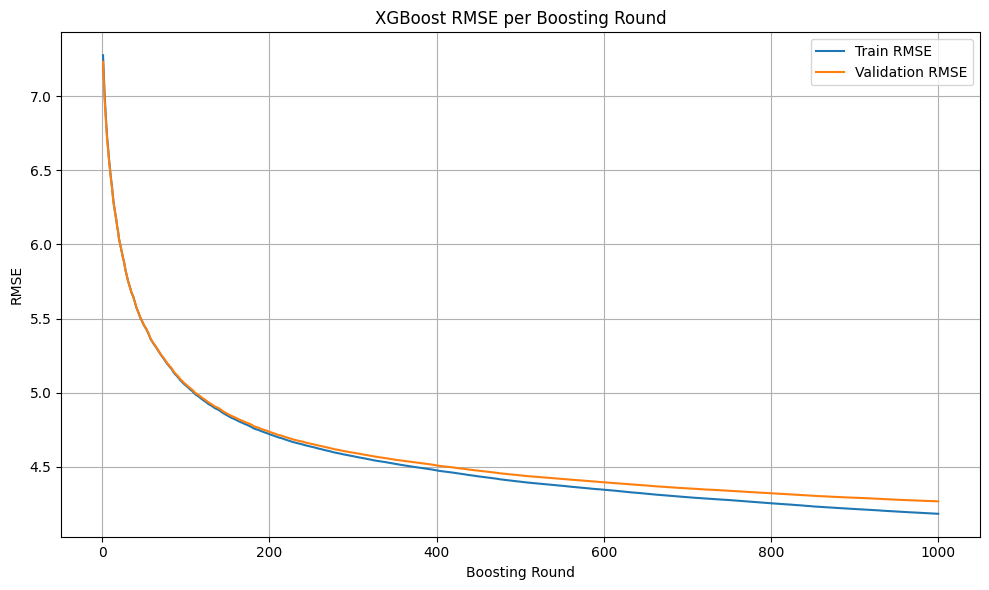

<Figure size 1000x600 with 0 Axes>

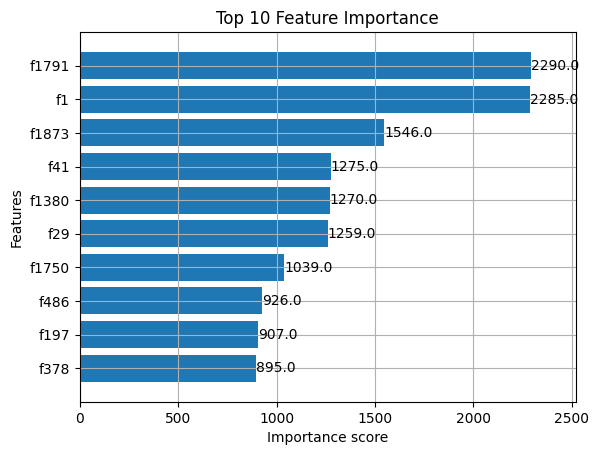

In [21]:
params = {
    'objective': 'reg:squarederror',
    "tree_method": "hist", "device": "cuda",# Regression task
    #"tree_method": "gpu_hist", # or "hist" for cpu
    'eval_metric': 'rmse',  # Root Mean Squared Error
    'max_depth': 8,  # Depth of trees
    'learning_rate': 0.1,  # Learning rate
    'colsample_bytree': 0.8,  # Column sampling rate
    'subsample': 0.8,  # Subsample ratio
    'seed': 42  # For reproducibility
}

# Step 3: Train the model with early stopping on validation set
num_round = 1000  # Specify the number of boosting rounds
evals = [(dtrain, 'train'), (dval, 'eval')]  # Track both training and validation performance
evals_result = {}
# Train the model
bst = xgb.train(
    params,
    dtrain,
    num_round,
    evals,
    early_stopping_rounds=10,  # Stop early if validation metric doesn't improve
    verbose_eval=50,
    evals_result=evals_result# Print evaluation results every 10 rounds
)

# Step 4: Predict on the test set
y_pred = bst.predict(dtest)

# Step 5: Evaluate the model performance
# RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2: {r2:.4f}")

# Step 6: Plot evaluation curves (training/validation RMSE)
#results = bst.eval_metrics
train_rmse = evals_result['train']['rmse']
val_rmse = evals_result['eval']['rmse']
epochs = range(1, len(train_rmse) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_rmse, label='Train RMSE')
plt.plot(epochs, val_rmse, label='Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE per Boosting Round')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Step 7: Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(bst, importance_type="weight", max_num_features=10, height=0.8)
plt.title('Top 10 Feature Importance')
plt.show()

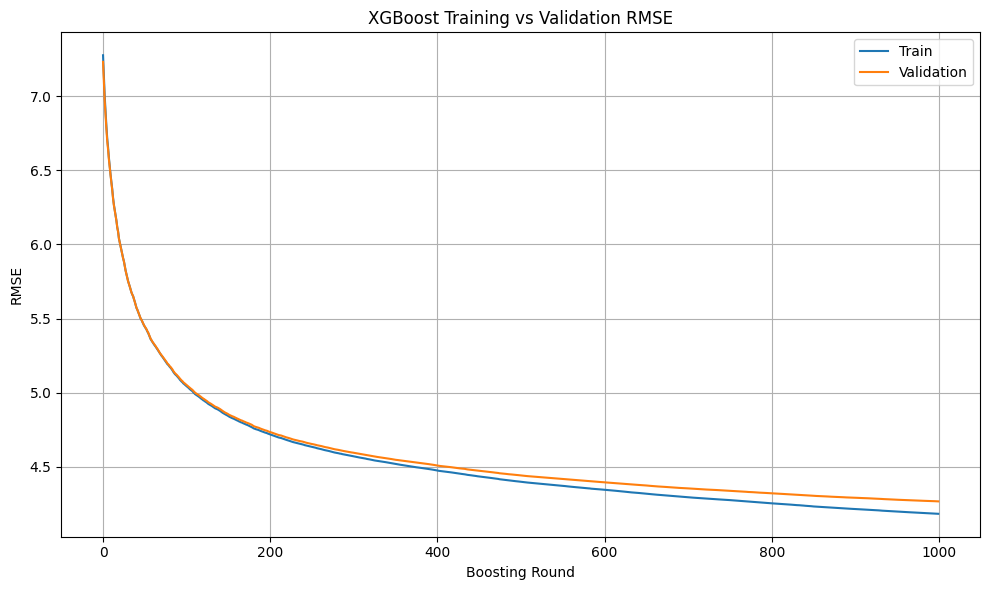

In [22]:
epochs = len(evals_result["train"]["rmse"])
x_axis = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result["train"]["rmse"], label="Train")
plt.plot(x_axis, evals_result["eval"]["rmse"], label="Validation")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("XGBoost Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/home/vmsavla/.local/lib/python3.11/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/home/vmsavla/.local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:13:11] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/vmsavla/.local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:13:11] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:7.36484	eval-rmse:7.31502
[50]	train-rmse:5.89925	eval-rmse:5.89683
[100]	train-rmse:5.45960	eval-rmse:5.46167
[150]	train-rmse:5.21318	eval-rmse:5.21958
[200]	train-rmse:5.05350	eval-rmse:5.06312
[250]	train-rmse:4.93777	eval-rmse:4.94939
[300]	train-rmse:4.84910	eval-rmse:4.86314
[350]	train-rmse:4.78038	eval-rmse:4.79525
[400]	train-rmse:4.72377	eval-rmse:4.74015
[450]	train-rmse:4.67814	eval-rmse:4.69635
[500]	train-rmse:4.63623	eval-rmse:4.65604
[550]	train-rmse:4.60030	eval-rmse:4.62275
[600]	train-rmse:4.56820	eval-rmse:4.59273
[650]	train-rmse:4.54049	eval-rmse:4.56735
[700]	train-rmse:4.51488	eval-rmse:4.54405
[750]	train-rmse:4.49093	eval-rmse:4.52243
[800]	train-rmse:4.46854	eval-rmse:4.50244
[850]	train-rmse:4.44800	eval-rmse:4.48398
[900]	train-rmse:4.42854	eval-rmse:4.46680
[950]	train-rmse:4.41032	eval-rmse:4.45079
[999]	train-rmse:4.39300	eval-rmse:4.43575
Test RMSE: 4.5048
Test R^2: 0.6218


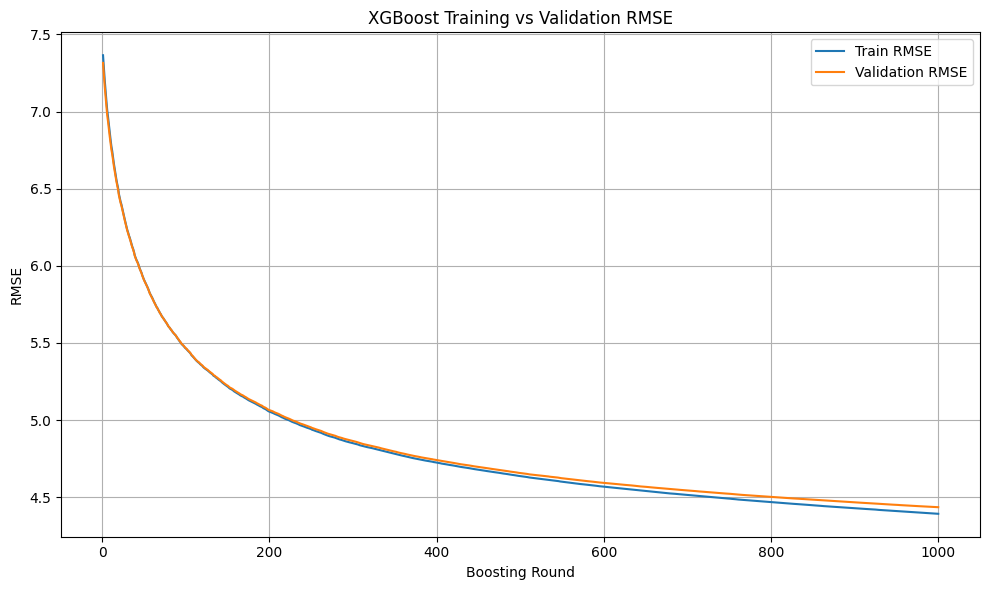

<Figure size 1000x600 with 0 Axes>

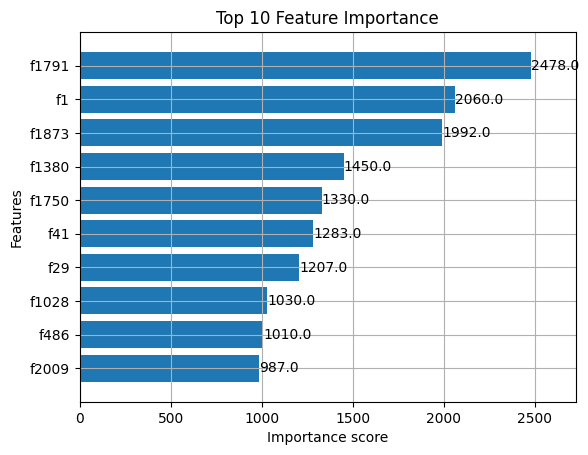

In [27]:
params = {
    'objective': 'reg:squarederror',
    "tree_method": "hist", "device": "cuda",# Regression task
    #"tree_method": "gpu_hist", # or "hist" for cpu
    'eval_metric': 'rmse',  # Root Mean Squared Error
    'max_depth': 8,  # Depth of trees
    'learning_rate': 0.05,  # Learning rate
    'colsample_bytree': 0.8,  # Column sampling rate
    'subsample': 0.8,  # Subsample ratio
    'seed': 42  # For reproducibility
}

# Step 3: Train the model with early stopping on validation set
num_round = 1000  # Specify the number of boosting rounds
evals = [(dtrain, 'train'), (dval, 'eval')]  # Track both training and validation performance
evals_result = {}
# Train the model
bst = xgb.train(
    params,
    dtrain,
    num_round,
    evals,
    early_stopping_rounds=10,  # Stop early if validation metric doesn't improve
    verbose_eval=50,
    evals_result=evals_result# Print evaluation results every 10 rounds
)

# Step 4: Predict on the test set
y_pred = bst.predict(dtest)

# Step 5: Evaluate the model performance
# RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2: {r2:.4f}")

# Step 6: Plot evaluation curves (training/validation RMSE)
#results = bst.eval_metrics
train_rmse = evals_result['train']['rmse']
val_rmse = evals_result['eval']['rmse']
epochs = range(1, len(train_rmse) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_rmse, label='Train RMSE')
plt.plot(epochs, val_rmse, label='Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost Training vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Step 7: Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(bst, importance_type="weight", max_num_features=10, height=0.8)
plt.title('Top 10 Feature Importance')
plt.show()

In [ ]:
import xgboost as xgb
import numpy as np

seeds = [42, 52, 62]
models = []
preds = []

for seed in seeds:
    model = xgb.train(
        params={
            'objective': 'reg:squarederror',
            'tree_method': 'hist',
            'nthread': 10,
            'max_depth': 8,
            'eta': 0.1,
            'seed': seed,
        },
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dval, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    models.append(model)
    preds.append(model.predict(dtest))

# Average predictions
final_preds = np.mean(preds, axis=0)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_test, final_preds, squared=False)
r2 = r2_score(y_test, final_preds)

print(f"Ensemble Test RMSE: {rmse:.4f}")
print(f"Ensemble Test R^2: {r2:.4f}")

[0]	train-rmse:7.27324	eval-rmse:7.22787
[100]	train-rmse:5.03044	eval-rmse:5.03980
[200]	train-rmse:4.70678	eval-rmse:4.72382
[300]	train-rmse:4.56066	eval-rmse:4.58728
[400]	train-rmse:4.46887	eval-rmse:4.50489
[500]	train-rmse:4.39386	eval-rmse:4.43878
[600]	train-rmse:4.33720	eval-rmse:4.39059
[700]	train-rmse:4.28671	eval-rmse:4.34790
[800]	train-rmse:4.24495	eval-rmse:4.31521
[900]	train-rmse:4.21020	eval-rmse:4.28853
[999]	train-rmse:4.17586	eval-rmse:4.26278
[0]	train-rmse:7.27324	eval-rmse:7.22787
[100]	train-rmse:5.03044	eval-rmse:5.03980
[200]	train-rmse:4.70678	eval-rmse:4.72382
[300]	train-rmse:4.56066	eval-rmse:4.58728
[400]	train-rmse:4.46887	eval-rmse:4.50489
[500]	train-rmse:4.39386	eval-rmse:4.43878
[600]	train-rmse:4.33720	eval-rmse:4.39059
[700]	train-rmse:4.28671	eval-rmse:4.34790

In [ ]:
pip install optuna

In [ ]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare DMatrix (assuming you already have these)
# dtrain = xgb.DMatrix(X_train_final, label=y_train_final)

def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'gpu_hist',  # or "hist" if running on CPU
        'device': 'cuda',
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),  # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),    # L1 regularization
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    cv_results = xgb.cv(
        param,
        dtrain,
        num_boost_round=800,
        nfold=3,
        early_stopping_rounds=10,
        stratified=False,
        seed=42,
        verbose_eval=100
    )

    return cv_results['test-rmse-mean'].min()

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Print best params
print("Best trial:")
print(f"  Value (best RMSE): {study.best_value:.4f}")
print("  Params:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")